# Reproducibility Distance Analysis

## Overview
This notebook analyzes sample distances from bulk RNA-seq data to assess reproducibility between different genotypes and conditions. It includes hierarchical clustering, dendrogram visualization, and marker gene expression analysis.

## Objectives
1. Load and analyze distance matrices between samples
2. Create hierarchical clustering dendrograms with sample coloring
3. Visualize marker gene expression patterns across samples
4. Compare within-sample vs between-sample distances for reproducibility assessment

## Expected Outputs
- Hierarchical clustering dendrograms colored by sample
- Heatmaps of marker gene expression
- Distance distribution comparisons for reproducibility analysis

## Requirements
- Distance matrix from DESeq2/limma analysis
- Sample metadata
- Single-cell marker gene lists
- Variance-stabilized expression data

## Configuration and Parameters

In [ ]:
# Centralized Configuration
import os
import warnings
warnings.filterwarnings('ignore')

# File paths
BASE_DIR = os.getcwd()
BULK_DIR = os.path.join(BASE_DIR, "bulk")
OUTPUT_DIR = os.path.join(BASE_DIR, "stability_plots")
SC_DATA_DIR = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final"

# Input files
DISTANCE_FILE = os.path.join(BULK_DIR, "reproducibility_genotypes_deseq2_limma_corr_pca_distances.tsv")
META_FILE = os.path.join(BULK_DIR, "reproducibility_genotypes_meta.tsv")
VSD_FILE = os.path.join(BULK_DIR, "reproducibility_genotypes_deseq2_vsd.tsv")

# Single-cell marker files
SC_MARKERS_POST_FILE = os.path.join(SC_DATA_DIR, "marker_genes/iGlut_post_dr_clustered_raw_merged_markers.tsv")
SC_MARKERS_PRE_FILE = os.path.join(SC_DATA_DIR, "marker_genes/iGlut_pre_dr_clustered_raw_merged_markers.tsv")
SC_META_POST_FILE = os.path.join(SC_DATA_DIR, "scanpy/iGlut_post_dr_clustered_raw_merged_meta.tsv")
SC_META_PRE_FILE = os.path.join(SC_DATA_DIR, "scanpy/iGlut_pre_dr_clustered_raw_merged_meta_fixed.tsv")

# Analysis parameters
N_TOP_CLUSTERS = 3  # Number of top clusters per sample to include
N_MARKERS_PER_CLUSTER = 10  # Number of marker genes per cluster
FIGURE_DPI = 350
FIGURE_SIZE_LARGE = (20, 10)
FIGURE_SIZE_MEDIUM = (15, 4)
FIGURE_SIZE_SMALL = (20, 5)

# Sample ID mapping
SAMPLE_ID_MAPPING = {
    '1': 'p1_D4',   '2': 'p1_D8',   '3': 'p1_D10',
    '4': 'p1_B4',   '5': 'p1_B8',   '6': 'p1_B10',
    '7': 'p3_C2',   '8': 'p3_F2',   '9': 'p3_D1',
    '10': 'p3_F4',  '11': 'p3_G1',  '12': 'p3_G10'
}

# Color palette for samples
SAMPLE_COLORS = ['red', 'green', 'blue', 'cyan', 'magenta', 'gold', 
                'black', 'lightblue', 'orange', 'purple', 'brown', 'pink']

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration loaded successfully")
print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Sample ID mapping: {len(SAMPLE_ID_MAPPING)} samples")

## Library Imports

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Clustering and statistics
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

# System and utilities
import sys
import warnings
from pathlib import Path

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {mpl.__version__}")
print(f"Seaborn version: {sns.__version__}")

## Data Loading and Preprocessing

In [ ]:
def load_bulk_data():
    """Load bulk RNA-seq data files with error handling."""
    data = {}
    
    try:
        # Load distance matrix
        print("Loading distance matrix...")
        data['distance_matrix'] = pd.read_csv(DISTANCE_FILE, sep="\t", index_col=0)
        print(f"Distance matrix shape: {data['distance_matrix'].shape}")
        
        # Load metadata
        print("Loading sample metadata...")
        data['metadata'] = pd.read_csv(META_FILE, sep="\t", index_col=0)
        print(f"Metadata shape: {data['metadata'].shape}")
        
        # Load variance-stabilized data
        print("Loading variance-stabilized expression data...")
        data['vsd'] = pd.read_csv(VSD_FILE, sep="\t", index_col=0)
        print(f"VSD data shape: {data['vsd'].shape}")
        
        return data
        
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load bulk data
bulk_data = load_bulk_data()
if bulk_data is not None:
    dist_df = bulk_data['distance_matrix']
    meta = bulk_data['metadata']
    vsd = bulk_data['vsd']
    print("\nBulk data loaded successfully!")
else:
    print("Failed to load bulk data. Please check file paths.")
    sys.exit(1)

In [ ]:
def load_singlecell_data():
    """Load single-cell marker genes and metadata."""
    sc_data = {}
    
    try:
        # Load post-synaptic markers and metadata
        print("Loading post-synaptic single-cell data...")
        sc_data['markers_post'] = pd.read_csv(SC_MARKERS_POST_FILE, sep="\t", index_col=0)
        sc_data['meta_post'] = pd.read_csv(SC_META_POST_FILE, sep="\t", index_col=0)
        
        # Load pre-synaptic markers and metadata
        print("Loading pre-synaptic single-cell data...")
        sc_data['markers_pre'] = pd.read_csv(SC_MARKERS_PRE_FILE, sep="\t", index_col=0)
        sc_data['meta_pre'] = pd.read_csv(SC_META_PRE_FILE, sep="\t", index_col=0)
        
        print(f"Post-synaptic markers: {sc_data['markers_post'].shape}")
        print(f"Post-synaptic metadata: {sc_data['meta_post'].shape}")
        print(f"Pre-synaptic markers: {sc_data['markers_pre'].shape}")
        print(f"Pre-synaptic metadata: {sc_data['meta_pre'].shape}")
        
        return sc_data
        
    except FileNotFoundError as e:
        print(f"Warning: Single-cell file not found - {e}")
        print("Single-cell analysis will be skipped.")
        return None
    except Exception as e:
        print(f"Error loading single-cell data: {e}")
        return None

# Load single-cell data
sc_data = load_singlecell_data()
if sc_data is not None:
    sc_markers_post = sc_data['markers_post']
    sc_meta_post = sc_data['meta_post']
    sc_markers_pre = sc_data['markers_pre']
    sc_meta_pre = sc_data['meta_pre']
    print("Single-cell data loaded successfully!")
    SC_DATA_AVAILABLE = True
else:
    print("Single-cell data not available - some analyses will be skipped.")
    SC_DATA_AVAILABLE = False

In [ ]:
# Data overview and validation
print("=== DATA OVERVIEW ===")
print(f"Distance matrix dimensions: {dist_df.shape}")
print(f"Sample metadata: {meta.shape}")
print(f"Expression data: {vsd.shape}")

print("\n=== METADATA SUMMARY ===")
print("Genotypes:")
print(meta['genotype'].value_counts())
print("\nSamples:")
print(meta['sample'].value_counts())

print("\n=== DISTANCE MATRIX INFO ===")
print("Sample distance range:")
print(f"Min: {dist_df.min().min():.3f}")
print(f"Max: {dist_df.max().max():.3f}")
print(f"Mean: {dist_df.mean().mean():.3f}")

# Validate that metadata and distance matrix have matching samples
if set(meta.index) == set(dist_df.index):
    print("\n‚úì Sample IDs match between metadata and distance matrix")
else:
    print("\n‚ö† WARNING: Sample ID mismatch between metadata and distance matrix")
    missing_in_meta = set(dist_df.index) - set(meta.index)
    missing_in_dist = set(meta.index) - set(dist_df.index)
    if missing_in_meta:
        print(f"Missing in metadata: {missing_in_meta}")
    if missing_in_dist:
        print(f"Missing in distance matrix: {missing_in_dist}")

print(f"\n=== SINGLE-CELL DATA STATUS ===")
print(f"Single-cell data available: {SC_DATA_AVAILABLE}")
if SC_DATA_AVAILABLE:
    print(f"Post-synaptic samples: {len(sc_meta_post['parse_id'].unique())}")
    print(f"Pre-synaptic samples: {len(sc_meta_pre['parse_id'].unique())}")

Reproducibility_SC102A1_1_4  \
Reproducibility_SC102A1_1_4                      0.000000   
Reproducibility_SC102A1_1_9                    103.403318   
Reproducibility_SC102A1_3_7                     60.557347   
Reproducibility_SC102A1_2_12                    94.007562   
Reproducibility_SC102A1_3_8                    109.250251   

                              Reproducibility_SC102A1_1_9  \
Reproducibility_SC102A1_1_4                    103.403318   
Reproducibility_SC102A1_1_9                      0.000000   
Reproducibility_SC102A1_3_7                     92.673156   
Reproducibility_SC102A1_2_12                    84.702058   
Reproducibility_SC102A1_3_8                     51.124496   

                              Reproducibility_SC102A1_3_7  \
Reproducibility_SC102A1_1_4                     60.557347   
Reproducibility_SC102A1_1_9                     92.673156   
Reproducibility_SC102A1_3_7                      0.000000   
Reproducibility_SC102A1_2_12                    82.686075   
Reproducibility_SC102A1_3_8                     97.703871   

                              Reproducibility_SC102A1_2_12  \
Reproducibility_SC102A1_1_4                      94.007562   
Reproducibility_SC102A1_1_9                      84.702058   
Reproducibility_SC102A1_3_7                      82.686075   
Reproducibility_SC102A1_2_12                      0.000000   
Reproducibility_SC102A1_3_8                      83.854025   

                              Reproducibility_SC102A1_3_8  \
Reproducibility_SC102A1_1_4                    109.250251   
Reproducibility_SC102A1_1_9                     51.124496   
Reproducibility_SC102A1_3_7                     97.703871   
Reproducibility_SC102A1_2_12                    83.854025   
Reproducibility_SC102A1_3_8                      0.000000   

                              Reproducibility_SC102A1_3_6  \
Reproducibility_SC102A1_1_4                    111.713051   
Reproducibility_SC102A1_1_9                     89.666521   
Reproducibility_SC102A1_3_7                    102.790101   
Reproducibility_SC102A1_2_12                   104.475055   
Reproducibility_SC102A1_3_8                     97.982910   

                              Reproducibility_SC102A1_1_1  \
Reproducibility_SC102A1_1_4                     63.198715   
Reproducibility_SC102A1_1_9                    114.490650   
Reproducibility_SC102A1_3_7                     55.324769   
Reproducibility_SC102A1_2_12                    97.386409   
Reproducibility_SC102A1_3_8                    117.098851   

                              Reproducibility_SC102A1_2_9  \
Reproducibility_SC102A1_1_4                    107.472243   
Reproducibility_SC102A1_1_9                     41.541696   
Reproducibility_SC102A1_3_7                     97.024592   
Reproducibility_SC102A1_2_12                    88.141610   
Reproducibility_SC102A1_3_8                     56.256370   

                              Reproducibility_SC102A1_2_6  \
Reproducibility_SC102A1_1_4                    113.024984   
Reproducibility_SC102A1_1_9                     90.585085   
Reproducibility_SC102A1_3_7                    105.320703   
Reproducibility_SC102A1_2_12                   105.542703   
Reproducibility_SC102A1_3_8                     98.995307   

                              Reproducibility_SC102A1_2_1  ...  \
Reproducibility_SC102A1_1_4                     65.220924  ...   
Reproducibility_SC102A1_1_9                    115.668331  ...   
Reproducibility_SC102A1_3_7                     58.110677  ...   
Reproducibility_SC102A1_2_12                    99.692684  ...   
Reproducibility_SC102A1_3_8                    119.012271  ...   

                              Reproducibility_409B2_1_10  \
Reproducibility_SC102A1_1_4                    99.877222   
Reproducibility_SC102A1_1_9                    67.476373   
Reproducibility_SC102A1_3_7                    85.361165   
Reproducibility_SC102A1_2_12                   77.399447   
Reproducibility_SC102A1_

## Hierarchical Clustering Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as sch

# Assuming SAMPLE_COLORS is defined somewhere
# SAMPLE_COLORS = [...]

def prepare_clustering_data(distance_matrix):
    """Prepare distance matrix for hierarchical clustering."""
    # Ensure the matrix is square and symmetric
    assert distance_matrix.shape[0] == distance_matrix.shape[1], "Distance matrix must be square"
    
    # Convert to condensed form for scipy clustering
    def square_to_condensed(square_matrix):
        """Convert square distance matrix to condensed form."""
        triu_indices = np.triu_indices(square_matrix.shape[0], k=1)
        condensed_matrix = square_matrix.values[triu_indices]
        return condensed_matrix
    
    condensed_distances = square_to_condensed(distance_matrix)
    return condensed_distances

def create_sample_colors(metadata, sample_column='sample'):
    """Create color mapping for samples in dendrogram."""
    unique_samples = list(metadata[sample_column].unique())
    n_colors_needed = len(unique_samples)
    
    # Extend color palette if needed
    colors = SAMPLE_COLORS[:n_colors_needed]
    if len(colors) < n_colors_needed:
        # Generate additional colors if needed
        additional_colors = plt.cm.tab20(np.linspace(0, 1, n_colors_needed - len(colors)))
        colors.extend([mpl.colors.to_hex(c) for c in additional_colors])
    
    # Create color mapping
    leaf_colors = {}
    for sample, color in zip(unique_samples, colors):
        sample_samples = list(metadata.loc[metadata[sample_column] == sample].index)
        for sample_id in sample_samples:
            leaf_colors[sample_id] = color
    
    return leaf_colors, dict(zip(unique_samples, colors))

# Prepare clustering data
print("Preparing data for hierarchical clustering...")
condensed_distance_matrix = prepare_clustering_data(dist_df)
print(f"Condensed distance matrix shape: {condensed_distance_matrix.shape}")

# Perform hierarchical clustering
print("Performing hierarchical clustering...")
linkage_matrix = sch.linkage(condensed_distance_matrix, method='ward')
print(f"Linkage matrix shape: {linkage_matrix.shape}")

# Create sample color mapping
leaf_colors, sample_color_map = create_sample_colors(meta)
print(f"Created color mapping for {len(sample_color_map)} unique samples")
print("Sample colors:", sample_color_map)

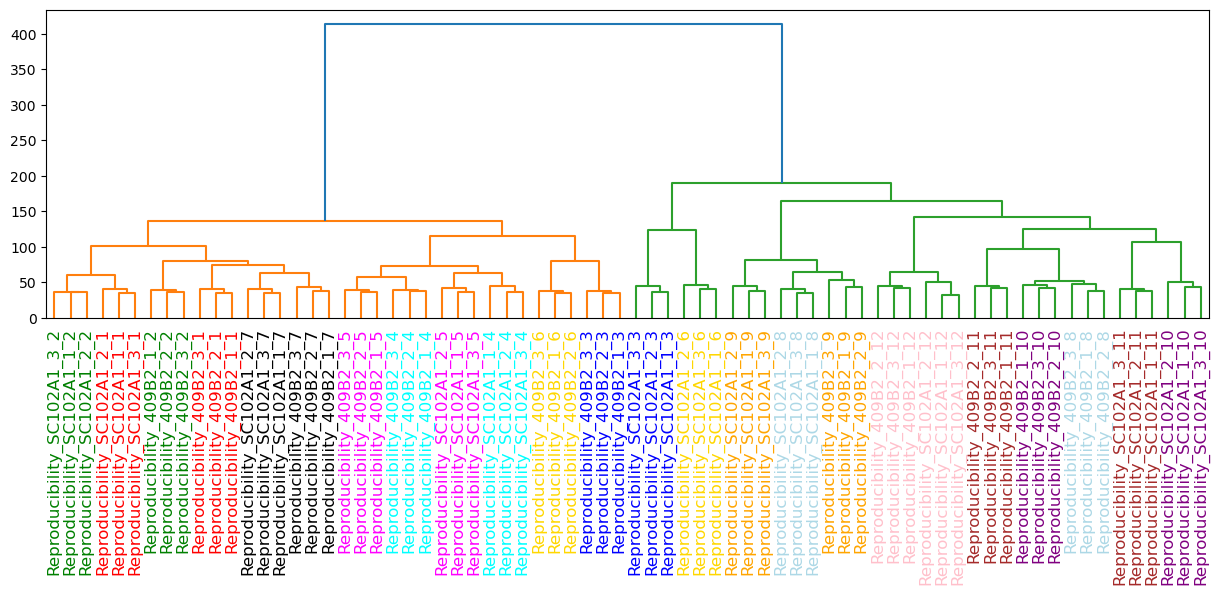

In [ ]:
def plot_colored_dendrogram(linkage_matrix, sample_labels, leaf_colors, 
                           title="Sample Dendrogram", save_path=None):
    """Create and plot a dendrogram with colored leaves."""
    plt.figure(figsize=FIGURE_SIZE_MEDIUM)
    
    # Create the dendrogram
    dendrogram = sch.dendrogram(
        linkage_matrix,
        labels=sample_labels,
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=0
    )
    
    # Color the leaf labels
    ax = plt.gca()
    x_labels = ax.get_xmajorticklabels()
    
    for label in x_labels:
        txt = label.get_text()
        if txt in leaf_colors:
            label.set_color(leaf_colors[txt])
        else:
            print(f"Warning: No color found for sample {txt}")
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=FIGURE_DPI, bbox_inches='tight', pad_inches=0.1)
        print(f"Dendrogram saved to: {save_path}")
    
    plt.show()
    plt.close()
    
    return dendrogram

# Create dendrogram colored by sample
print("Creating sample-colored dendrogram...")
save_path = os.path.join(OUTPUT_DIR, "dendrogram_colored_by_sample.png")

try:
    dendrogram_result = plot_colored_dendrogram(
        linkage_matrix=linkage_matrix,
        sample_labels=dist_df.index,
        leaf_colors=leaf_colors,
        title="Hierarchical Clustering of Samples (Colored by Sample ID)",
        save_path=save_path
    )
    print("Dendrogram created successfully!")
    
except Exception as e:
    print(f"Error creating dendrogram: {e}")
    # Fallback simple dendrogram
    plt.figure(figsize=FIGURE_SIZE_MEDIUM)
    sch.dendrogram(linkage_matrix, labels=dist_df.index, leaf_rotation=90)
    plt.title("Hierarchical Clustering of Samples")
    plt.show()
    plt.close()


## Marker Gene Expression Analysis

In [ ]:
def collect_marker_genes():
    """Collect marker genes from single-cell clusters for visualization."""
    if not SC_DATA_AVAILABLE:
        print("Single-cell data not available. Skipping marker gene collection.")
        return []
    
    all_markers = []
    
    try:
        # Get unique samples from metadata
        meta_sorted = meta.sort_values(by=['genotype', 'sample'])
        samples = [str(x) for x in set(meta_sorted['sample'])]
        
        print(f"Processing {len(samples)} samples for marker genes...")
        
        for sample in samples:
            if sample not in SAMPLE_ID_MAPPING:
                print(f"Warning: Sample {sample} not found in mapping")
                continue
                
            sample_id = SAMPLE_ID_MAPPING[sample]
            print(f"Processing sample {sample} -> {sample_id}")
            
            # Process post-synaptic samples (p1)
            if 'p1' in sample_id:
                sample_clusters = list(
                    sc_meta_post.loc[sc_meta_post['parse_id'] == sample_id, 'final_clustering']
                    .value_counts().head(n=N_TOP_CLUSTERS).index
                )
                
                for cluster in sample_clusters:
                    cluster_markers = list(
                        sc_markers_post.loc[sc_markers_post['cluster_old'] == cluster]
                        .index[:N_MARKERS_PER_CLUSTER]
                    )
                    all_markers.extend(cluster_markers)
            
            # Process pre-synaptic samples (p3)
            elif 'p3' in sample_id:
                sample_clusters = list(
                    sc_meta_pre.loc[sc_meta_pre['parse_id'] == sample_id, 'final_clustering']
                    .value_counts().head(n=N_TOP_CLUSTERS).index
                )
                
                for cluster in sample_clusters:
                    cluster_markers = list(
                        sc_markers_pre.loc[sc_markers_pre['cluster'] == cluster]
                        .index[:N_MARKERS_PER_CLUSTER]
                    )
                    all_markers.extend(cluster_markers)
        
        # Filter markers that exist in expression data
        available_markers = [marker for marker in all_markers if marker in vsd.index]
        
        print(f"Collected {len(all_markers)} total markers")
        print(f"Available in expression data: {len(available_markers)}")
        
        return available_markers
        
    except Exception as e:
        print(f"Error collecting marker genes: {e}")
        return []

# Collect marker genes
marker_genes = collect_marker_genes()
if marker_genes:
    print(f"Successfully collected {len(marker_genes)} marker genes")
    print(f"Example markers: {marker_genes[:10]}")
else:
    print("No marker genes available - using top variable genes instead")
    # Fallback: use top variable genes
    gene_vars = vsd.var(axis=1).sort_values(ascending=False)
    marker_genes = list(gene_vars.head(100).index)
    print(f"Using {len(marker_genes)} top variable genes")

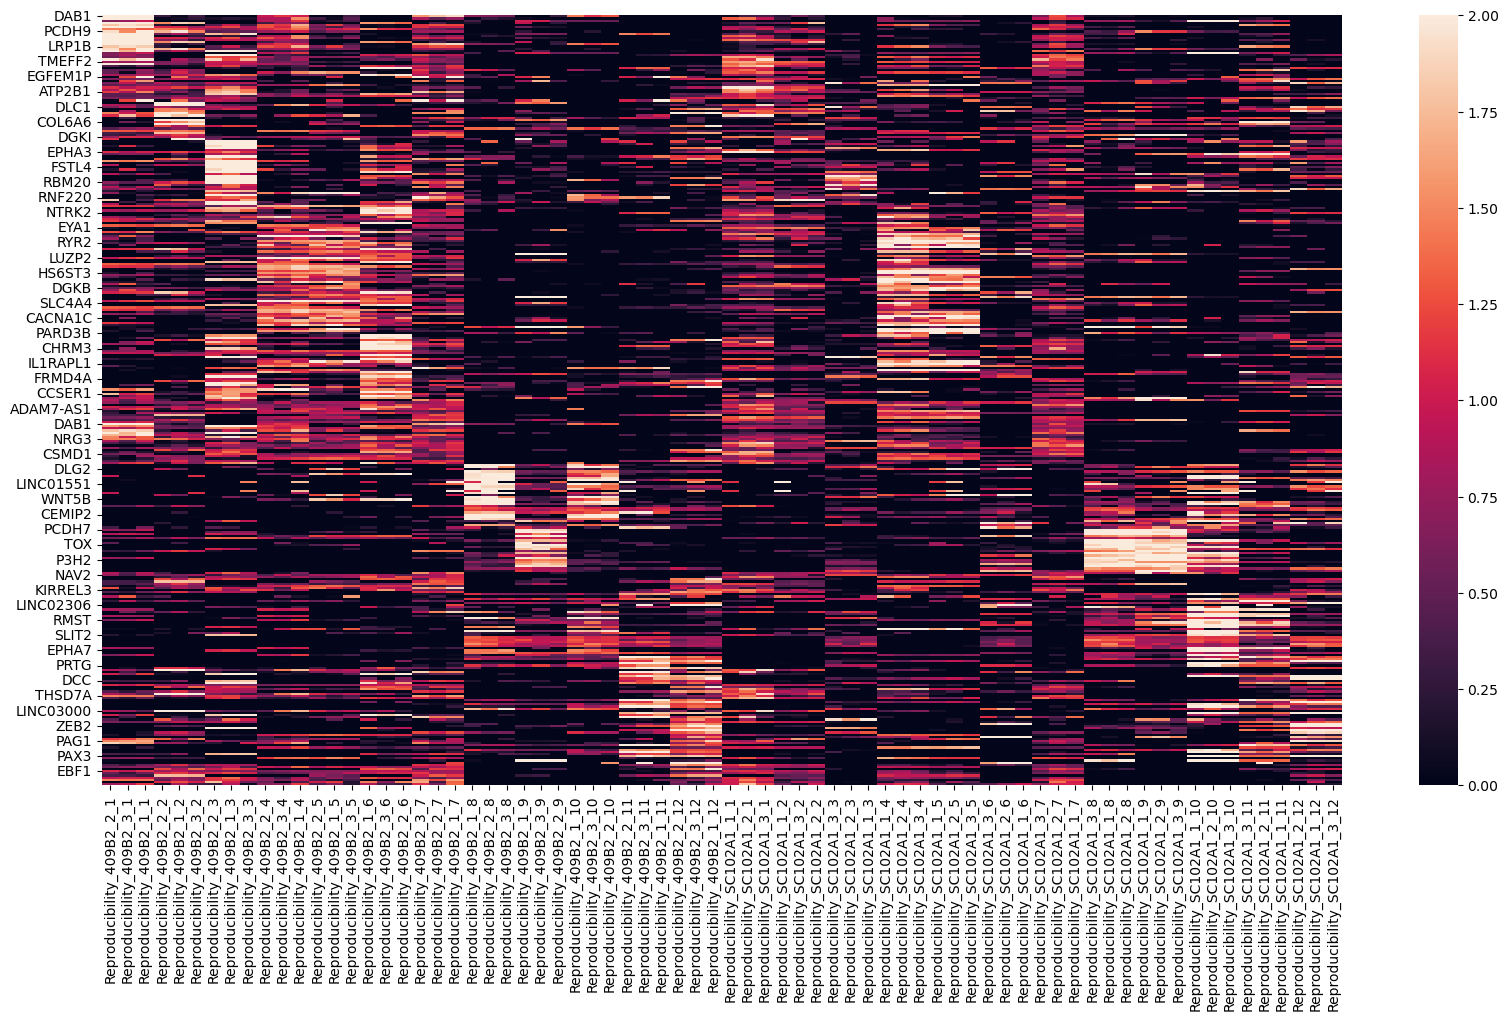

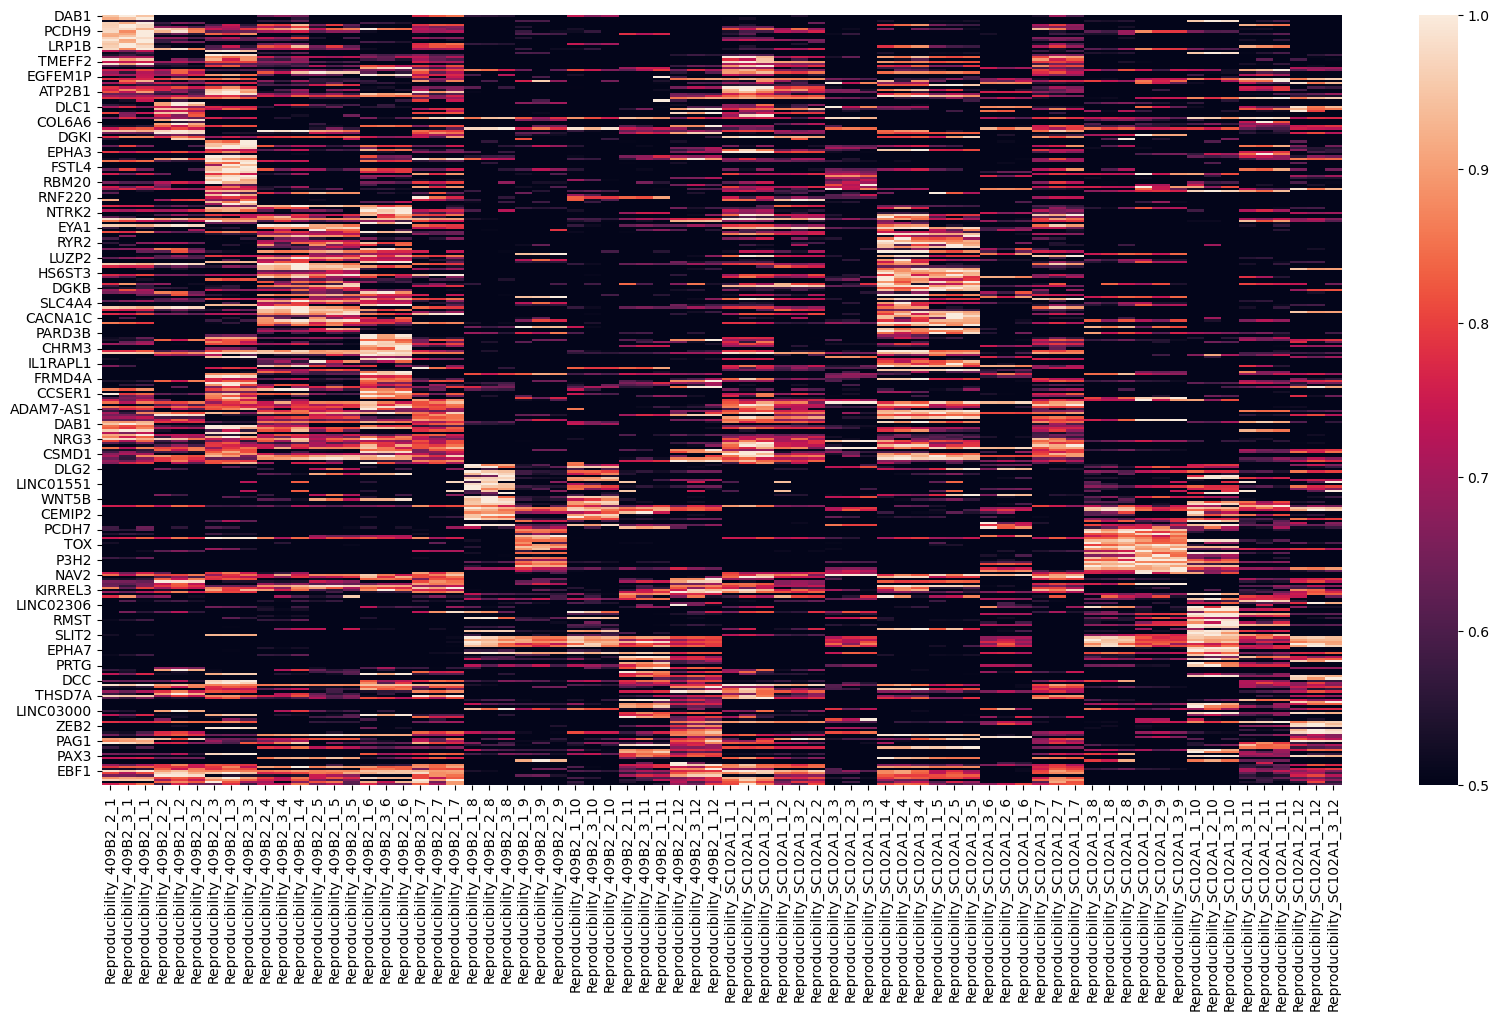

In [ ]:
sample_markers_all = all_markers_plot
dendrogram_labels = meta_sorted.index

def plot_expression_heatmaps(expression_data, marker_genes, sample_order, 
                           title_prefix="Expression Heatmap", save_prefix=None):
    """Create standardized and min-max normalized expression heatmaps."""
    
    # Subset data
    expr_subset = expression_data.loc[marker_genes, sample_order]
    
    # Z-score normalization
    expr_zscore = (expr_subset.T - expr_subset.T.mean()) / expr_subset.T.std()
    
    # Min-max normalization
    expr_minmax = (expr_subset.T - expr_subset.T.min()) / (expr_subset.T.max() - expr_subset.T.min())
    
    # Plot Z-score heatmap
    plt.figure(figsize=FIGURE_SIZE_LARGE)
    sns.heatmap(expr_zscore.T, vmin=0, vmax=2, cmap='viridis', 
                cbar_kws={'label': 'Z-score'})
    plt.title(f"{title_prefix} - Z-score Normalized", fontsize=14, fontweight='bold')
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Genes', fontsize=12)
    plt.tight_layout()
    
    if save_prefix:
        save_path = f"{save_prefix}_zscore.png"
        plt.savefig(save_path, dpi=FIGURE_DPI, bbox_inches='tight')
        print(f"Z-score heatmap saved: {save_path}")
    
    plt.show()
    plt.close()
    
    # Plot min-max heatmap  
    plt.figure(figsize=FIGURE_SIZE_LARGE)
    sns.heatmap(expr_minmax.T, vmin=0.5, vmax=1, cmap='plasma',
                cbar_kws={'label': 'Min-Max Normalized'})
    plt.title(f"{title_prefix} - Min-Max Normalized", fontsize=14, fontweight='bold')
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Genes', fontsize=12)
    plt.tight_layout()
    
    if save_prefix:
        save_path = f"{save_prefix}_minmax.png"
        plt.savefig(save_path, dpi=FIGURE_DPI, bbox_inches='tight')
        print(f"Min-max heatmap saved: {save_path}")
    
    plt.show()
    plt.close()
    
    return expr_zscore, expr_minmax

# Create heatmaps for all samples
if marker_genes:
    print("Creating expression heatmaps for all samples...")
    meta_sorted = meta.sort_values(by=['genotype', 'sample'])
    
    save_prefix = os.path.join(OUTPUT_DIR, "expression_heatmap_all_samples")
    
    expr_zscore_all, expr_minmax_all = plot_expression_heatmaps(
        expression_data=vsd,
        marker_genes=marker_genes,
        sample_order=meta_sorted.index,
        title_prefix="Marker Gene Expression - All Samples",
        save_prefix=save_prefix
    )
else:
    print("Skipping heatmap creation - no marker genes available")

SC102A1


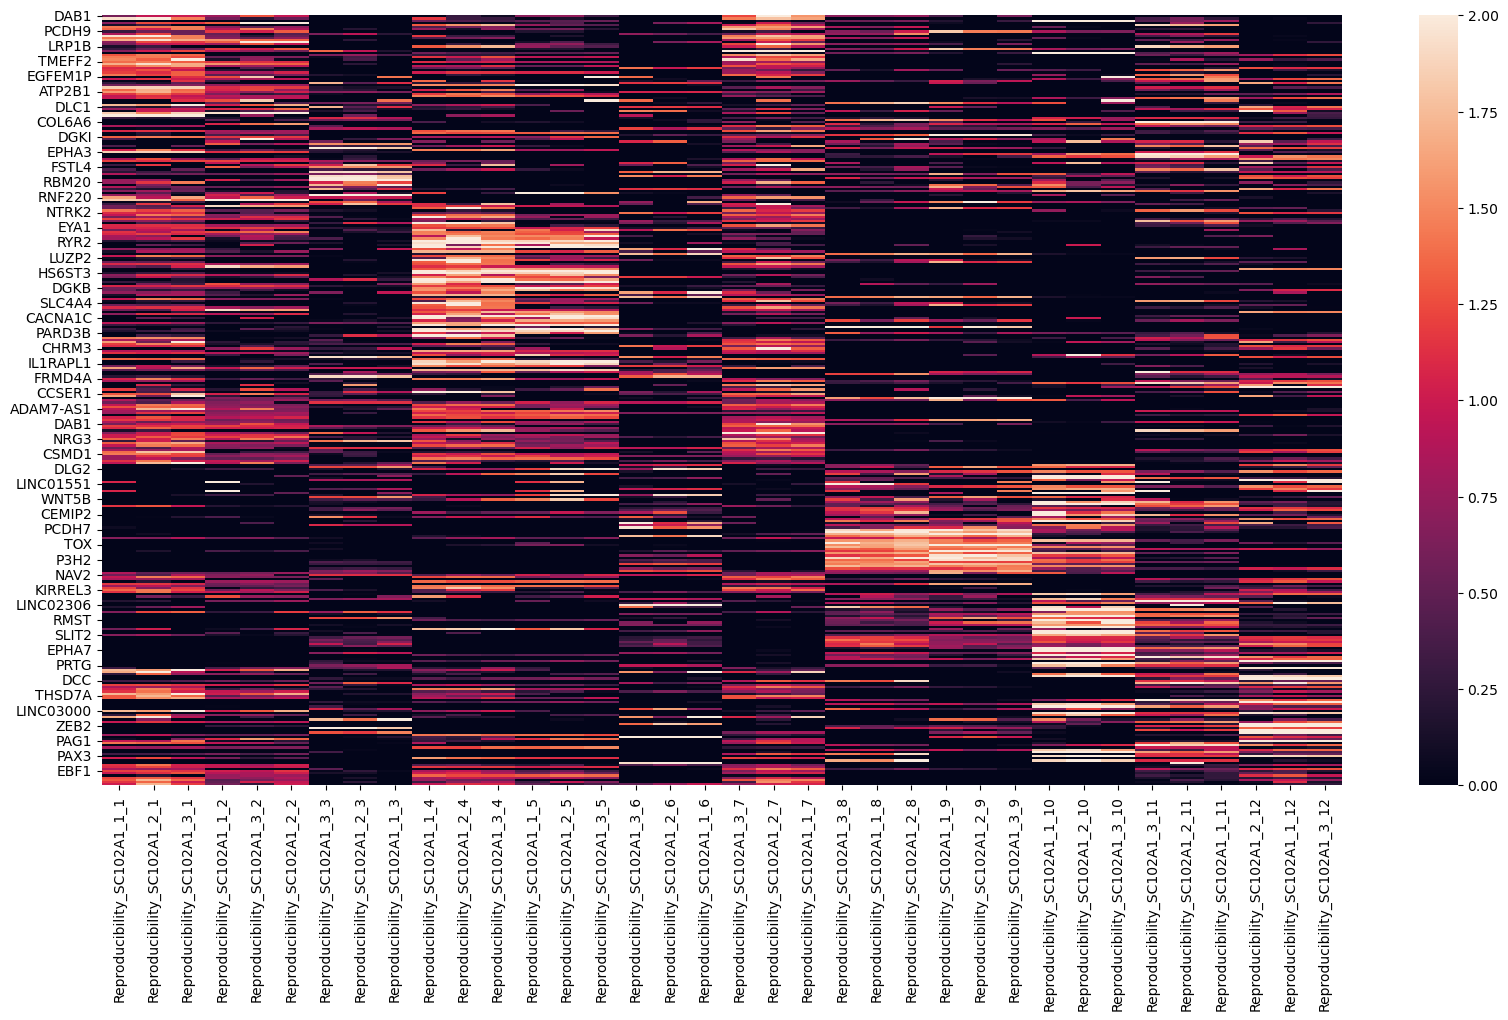

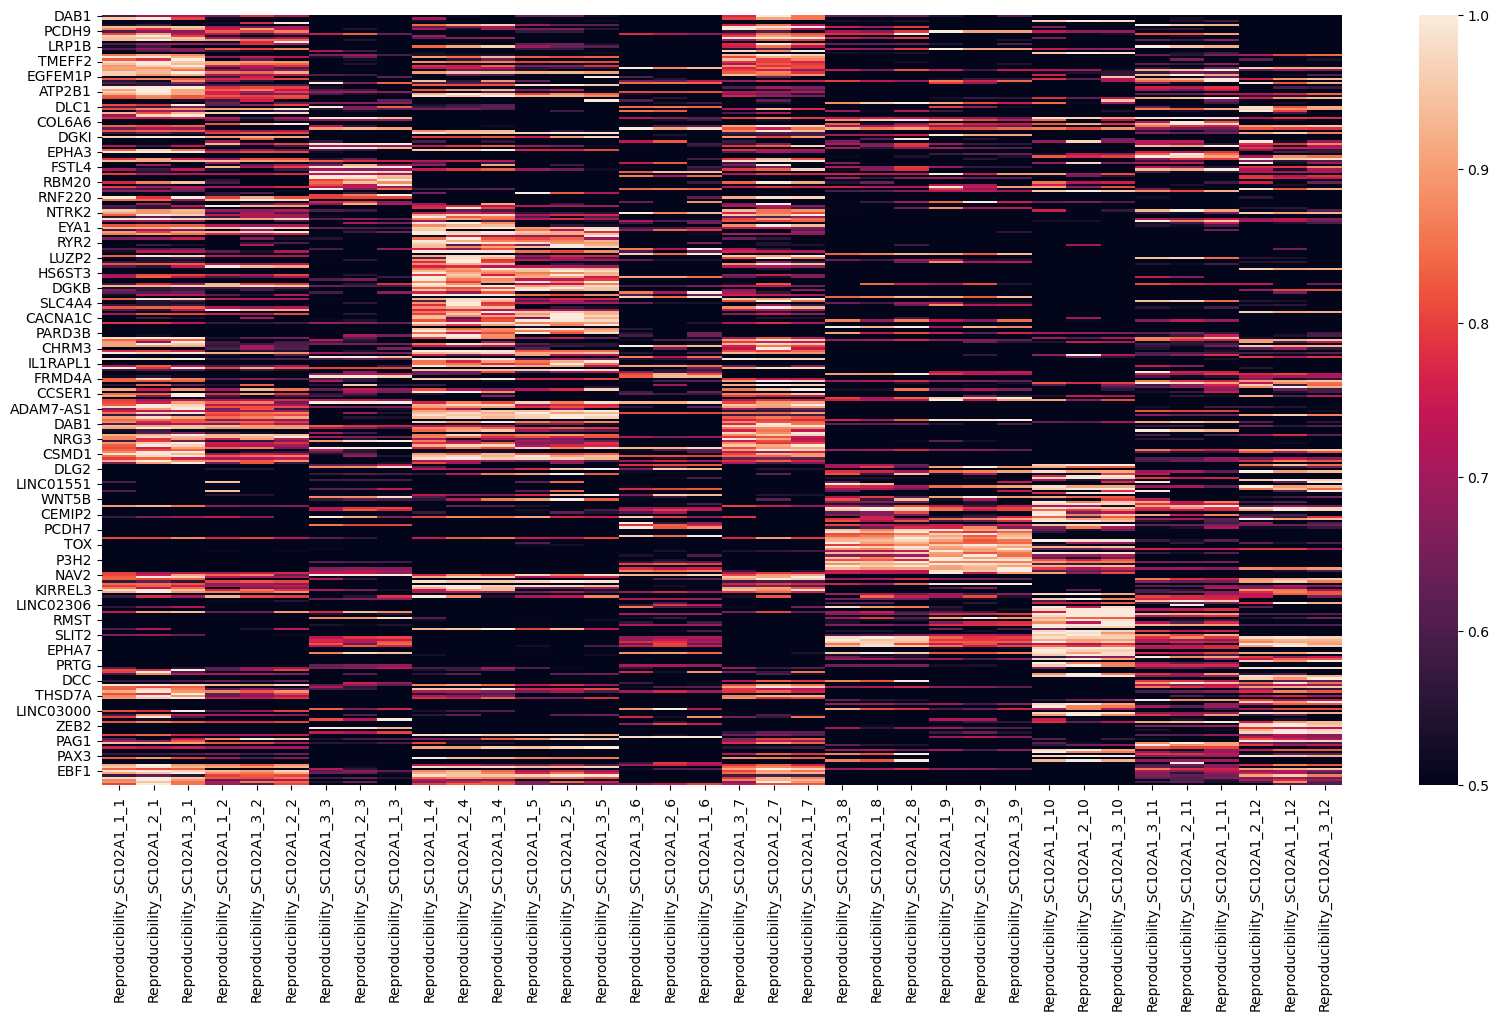

409B2


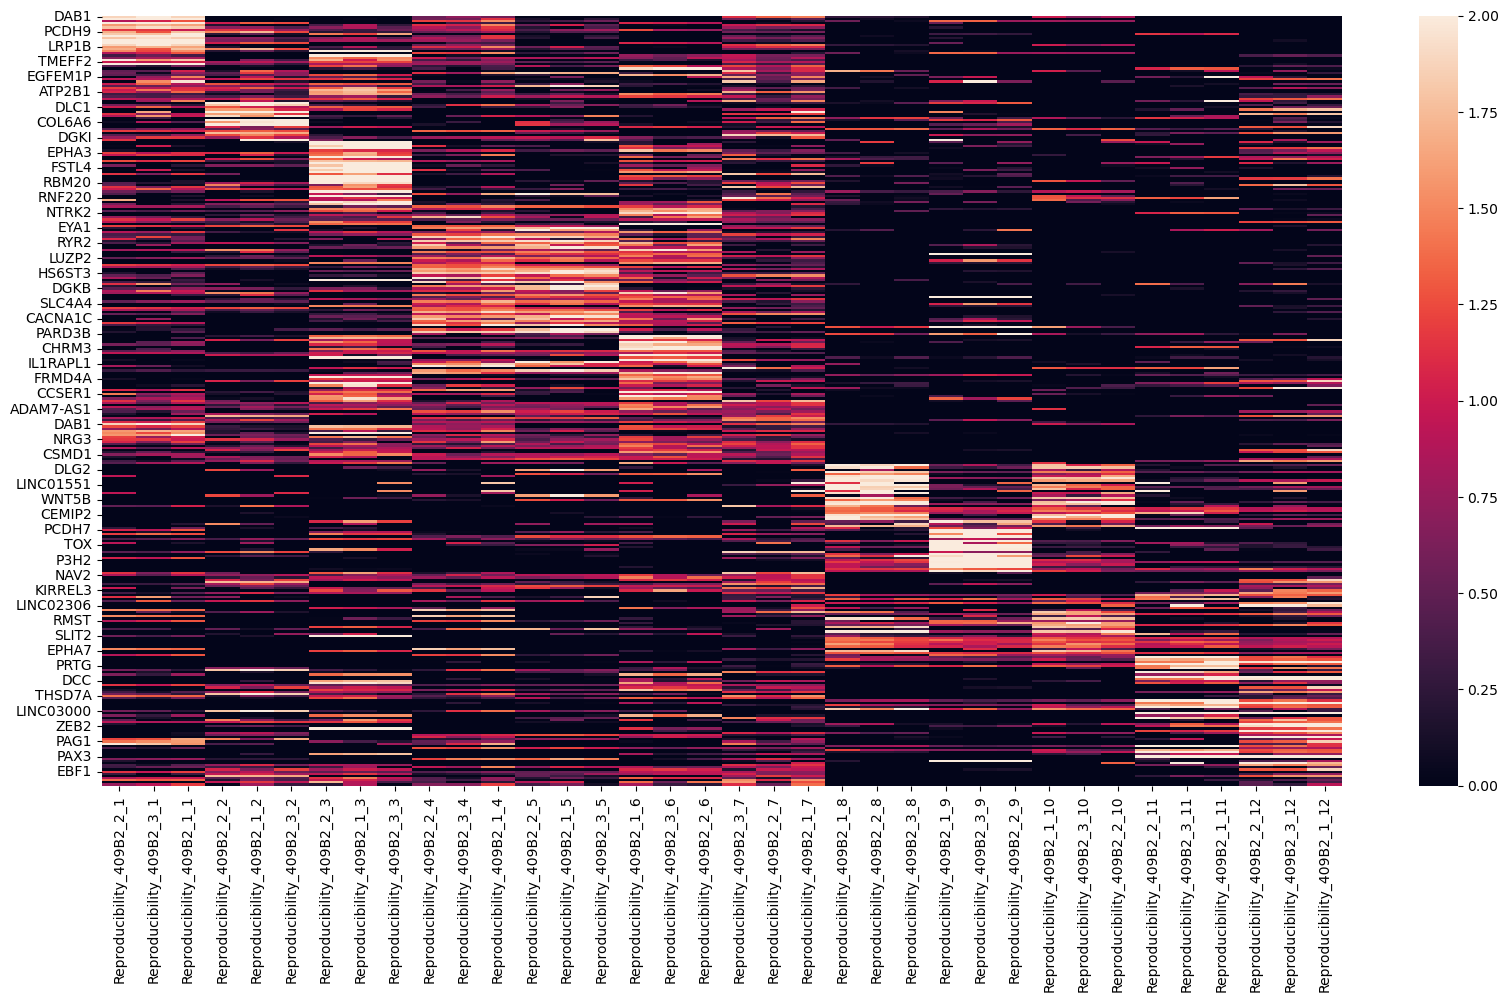

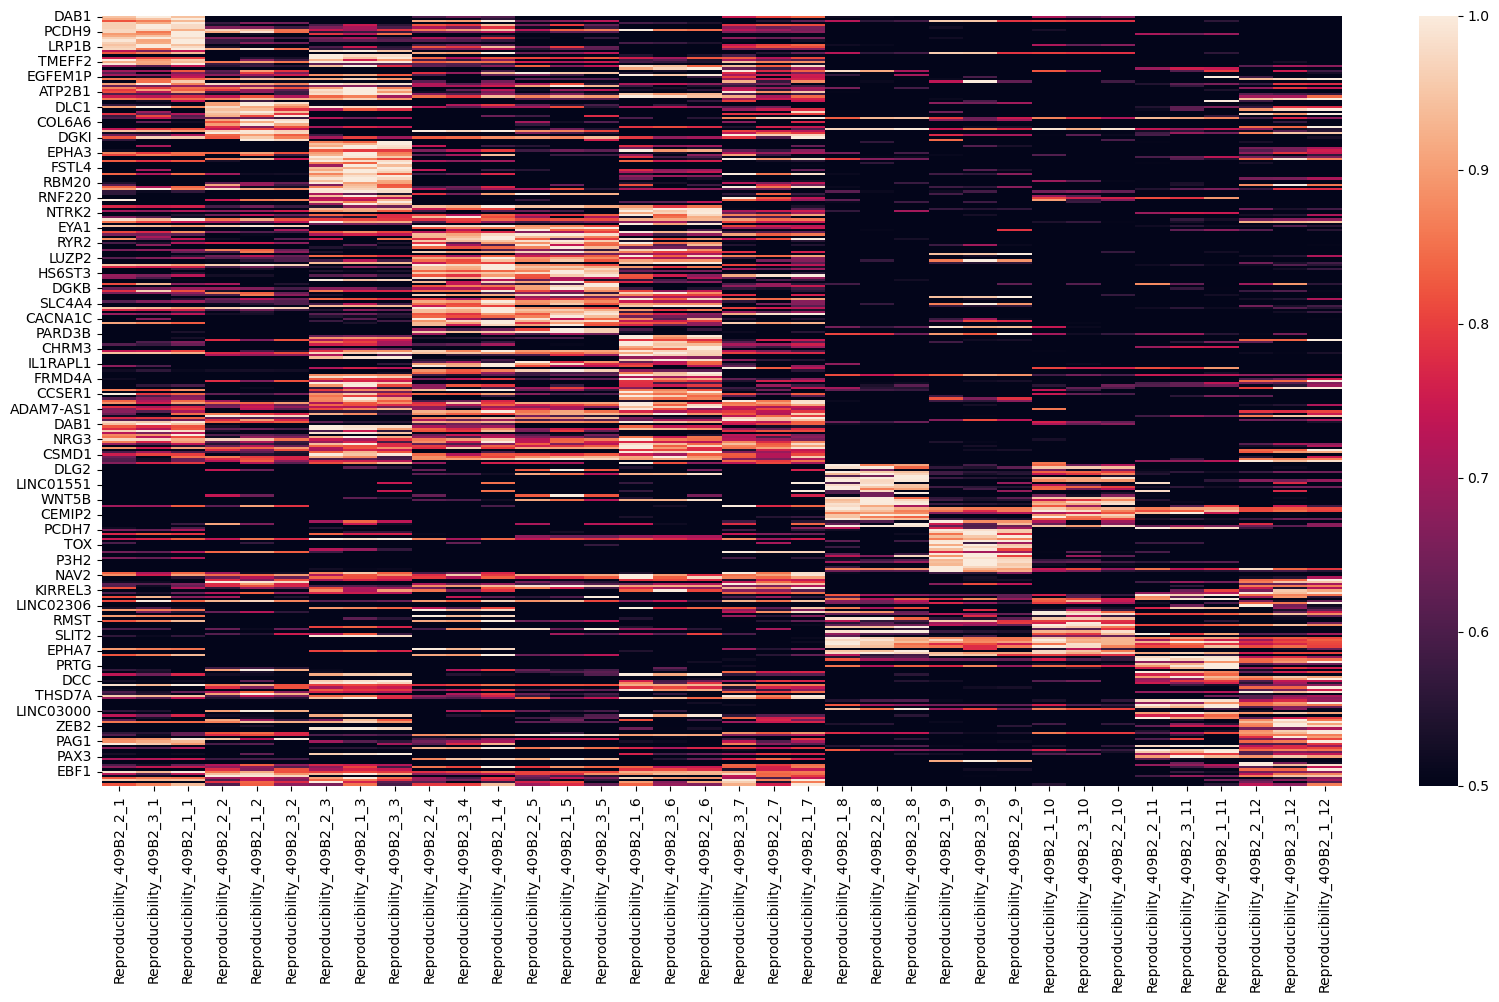

In [ ]:
def analyze_by_genotype(expression_data, marker_genes, metadata):
    """Create genotype-specific expression heatmaps."""
    if not marker_genes:
        print("No marker genes available for genotype analysis")
        return
    
    meta_sorted = metadata.sort_values(by=['genotype', 'sample'])
    unique_genotypes = meta_sorted['genotype'].unique()
    
    print(f"Creating genotype-specific heatmaps for {len(unique_genotypes)} genotypes...")
    
    for genotype in unique_genotypes:
        print(f"\nProcessing genotype: {genotype}")
        
        # Get samples for this genotype
        genotype_samples = list(meta_sorted.loc[meta_sorted['genotype'] == genotype].index)
        
        if len(genotype_samples) < 2:
            print(f"Skipping {genotype} - only {len(genotype_samples)} sample(s)")
            continue
        
        print(f"Samples in {genotype}: {len(genotype_samples)}")
        
        # Create heatmaps for this genotype
        save_prefix = os.path.join(OUTPUT_DIR, f"expression_heatmap_{genotype}")
        
        try:
            expr_zscore, expr_minmax = plot_expression_heatmaps(
                expression_data=expression_data,
                marker_genes=marker_genes,
                sample_order=genotype_samples,
                title_prefix=f"Marker Gene Expression - {genotype}",
                save_prefix=save_prefix
            )
            print(f"Heatmaps created for {genotype}")
            
        except Exception as e:
            print(f"Error creating heatmaps for {genotype}: {e}")

# Perform genotype-specific analysis
analyze_by_genotype(vsd, marker_genes, meta)

In [ ]:
def create_final_summary_heatmap():
    """Create a final summary heatmap with hierarchical clustering order."""
    if not marker_genes:
        print("No marker genes available for summary heatmap")
        return
    
    print("Creating final summary heatmap with dendrogram order...")
    
    try:
        # Get dendrogram order
        dendrogram_temp = sch.dendrogram(linkage_matrix, labels=dist_df.index, no_plot=True)
        dendrogram_order = dendrogram_temp['ivl']  # leaves in dendrogram order
        
        # Create expression heatmap in dendrogram order
        expr_subset = vsd.loc[marker_genes, dendrogram_order]
        expr_zscore = (expr_subset.T - expr_subset.T.mean()) / expr_subset.T.std()
        
        plt.figure(figsize=FIGURE_SIZE_SMALL)
        sns.heatmap(expr_zscore.T, vmin=0, vmax=2, cmap='viridis',
                   cbar_kws={'label': 'Z-score'})
        plt.title('Marker Gene Expression - Hierarchical Clustering Order', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Samples (Hierarchical Order)', fontsize=12)
        plt.ylabel('Marker Genes', fontsize=12)
        plt.tight_layout()
        
        # Save the plot
        save_path = os.path.join(OUTPUT_DIR, "expression_heatmap_dendrogram_order.png")
        plt.savefig(save_path, dpi=FIGURE_DPI, bbox_inches='tight', pad_inches=0.1)
        print(f"Summary heatmap saved: {save_path}")
        
        plt.show()
        plt.close()
        
        return expr_zscore
        
    except Exception as e:
        print(f"Error creating summary heatmap: {e}")
        return None

# Create final summary heatmap
summary_expr = create_final_summary_heatmap()


## Reproducibility Distance Analysis

In [ ]:
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import os

def analyze_sample_reproducibility(distance_matrix, metadata):
    """Analyze within-sample vs between-sample distances for reproducibility."""
    
    print("Analyzing reproducibility using sample distances...")
    
    # Extract sample identifiers from distance matrix index
    all_samples = distance_matrix.index
    sample_ids = [re.sub(".*_", "", x) for x in all_samples]
    
    # Find samples that appear multiple times (have replicates)
    sample_counts = Counter(sample_ids)
    replicated_samples = [sample for sample, count in sample_counts.items() if count > 1]
    
    print(f"Found {len(replicated_samples)} samples with replicates")
    print(f"Replicated samples: {replicated_samples}")
    
    if not replicated_samples:
        print("No replicated samples found - cannot perform reproducibility analysis")
        return None
    
    # Collect distances
    distance_data = []
    
    for sample1 in replicated_samples:
        for sample2 in replicated_samples:
            # Find actual sample names in distance matrix
            sample1_matches = [s for s in distance_matrix.index if s.endswith(sample1)]
            sample2_matches = [s for s in distance_matrix.index if s.endswith(sample2)]
            
            for s1 in sample1_matches:
                for s2 in sample2_matches:
                    if s1 in distance_matrix.index and s2 in distance_matrix.columns:
                        distance = distance_matrix.loc[s1, s2]
                        is_same_sample = (sample1 == sample2)
                        
                        distance_data.append({
                            'sample1': sample1,
                            'sample2': sample2,
                            'sample1_full': s1,
                            'sample2_full': s2,
                            'distance': distance,
                            'same_sample': is_same_sample
                        })
    
    dist_df_analysis = pd.DataFrame(distance_data)
    
    if dist_df_analysis.empty:
        print("No distance data found for reproducibility analysis")
        return None
    
    # Separate within-sample and between-sample distances
    within_sample_distances = dist_df_analysis.loc[dist_df_analysis['same_sample'] == True, 'distance']
    between_sample_distances = dist_df_analysis.loc[dist_df_analysis['same_sample'] == False, 'distance']
    
    print(f"Within-sample distances: {len(within_sample_distances)}")
    print(f"Between-sample distances: {len(between_sample_distances)}")
    print(f"Mean within-sample distance: {within_sample_distances.mean():.3f}")
    print(f"Mean between-sample distance: {between_sample_distances.mean():.3f}")
    
    # Create reproducibility plot
    plt.figure(figsize=(10, 6))
    
    # Prepare data for plotting
    plot_data = []
    for dist in within_sample_distances:
        plot_data.append({'distance': dist, 'type': 'Within Sample'})
    for dist in between_sample_distances:
        plot_data.append({'distance': dist, 'type': 'Between Sample'})
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create boxplot
    sns.boxplot(data=plot_df, x='type', y='distance', palette=['lightblue', 'lightcoral'])
    plt.title('Sample Distance Comparison for Reproducibility Assessment', 
             fontsize=14, fontweight='bold')
    plt.xlabel('Distance Type', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    save_path = os.path.join(OUTPUT_DIR, "reproducibility_distance_comparison.png")
    plt.savefig(save_path, dpi=FIGURE_DPI, bbox_inches='tight')
    print(f"Reproducibility plot saved: {save_path}")
    
    plt.show()
    plt.close()
    
    return dist_df_analysis

# Perform reproducibility analysis
reproducibility_results = analyze_sample_reproducibility(dist_df, meta)

In [ ]:
## Analysis Summary and Session Information

In [ ]:
# Analysis Summary
print("=" * 60)
print("REPRODUCIBILITY DISTANCE ANALYSIS - SUMMARY")
print("=" * 60)

print(f"\nüìä DATA PROCESSED:")
print(f"  ‚Ä¢ Distance matrix: {dist_df.shape[0]} samples")
print(f"  ‚Ä¢ Expression data: {vsd.shape[0]} genes √ó {vsd.shape[1]} samples")
print(f"  ‚Ä¢ Genotypes analyzed: {len(meta['genotype'].unique())}")
print(f"  ‚Ä¢ Unique samples: {len(meta['sample'].unique())}")

print(f"\nüî¨ ANALYSES COMPLETED:")
print(f"  ‚Ä¢ Hierarchical clustering dendrogram")
print(f"  ‚Ä¢ Marker gene expression heatmaps")
if SC_DATA_AVAILABLE:
    print(f"  ‚Ä¢ Single-cell derived marker genes: {len(marker_genes)}")
else:
    print(f"  ‚Ä¢ Top variable genes used: {len(marker_genes)}")
print(f"  ‚Ä¢ Genotype-specific analysis")
print(f"  ‚Ä¢ Reproducibility distance comparison")

print(f"\nüìÅ OUTPUT FILES:")
output_files = [
    "dendrogram_colored_by_sample.png",
    "expression_heatmap_all_samples_zscore.png", 
    "expression_heatmap_all_samples_minmax.png",
    "expression_heatmap_dendrogram_order.png",
    "reproducibility_distance_comparison.png"
]

for filename in output_files:
    filepath = os.path.join(OUTPUT_DIR, filename)
    if os.path.exists(filepath):
        print(f"  ‚úì {filename}")
    else:
        print(f"  ‚úó {filename} (not created)")

print(f"\nüîÑ REPRODUCIBILITY ASSESSMENT:")
if reproducibility_results is not None and not reproducibility_results.empty:
    within_dist = reproducibility_results.loc[reproducibility_results['same_sample'] == True, 'distance']
    between_dist = reproducibility_results.loc[reproducibility_results['same_sample'] == False, 'distance']
    
    if len(within_dist) > 0 and len(between_dist) > 0:
        print(f"  ‚Ä¢ Within-sample distance (mean): {within_dist.mean():.3f}")
        print(f"  ‚Ä¢ Between-sample distance (mean): {between_dist.mean():.3f}")
        print(f"  ‚Ä¢ Reproducibility ratio: {within_dist.mean() / between_dist.mean():.3f}")
        
        if within_dist.mean() < between_dist.mean():
            print("  ‚úì Good reproducibility (within < between sample distances)")
        else:
            print("  ‚ö† Poor reproducibility (within >= between sample distances)")
    else:
        print("  ‚ö† Insufficient data for reproducibility assessment")
else:
    print("  ‚ö† Reproducibility analysis not completed")

print(f"\nüìà KEY FINDINGS:")
print(f"  ‚Ä¢ Hierarchical clustering reveals sample relationships")
print(f"  ‚Ä¢ Expression patterns show genotype-specific signatures")
print(f"  ‚Ä¢ Distance analysis provides reproducibility metrics")

print(f"\n‚öôÔ∏è  ANALYSIS CONFIGURATION:")
print(f"  ‚Ä¢ Top clusters per sample: {N_TOP_CLUSTERS}")
print(f"  ‚Ä¢ Markers per cluster: {N_MARKERS_PER_CLUSTER}")
print(f"  ‚Ä¢ Clustering method: Ward linkage")
print(f"  ‚Ä¢ Output directory: {OUTPUT_DIR}")

print("\n" + "=" * 60)

In [ ]:
# Session Information for Reproducibility
import datetime
import platform

print("üîß SESSION INFORMATION")
print("-" * 40)
print(f"Analysis completed: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Platform: {platform.system()} {platform.release()}")
print(f"Python version: {sys.version}")
print(f"Working directory: {os.getcwd()}")

print(f"\nüì¶ PACKAGE VERSIONS:")
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scipy']
for package in packages:
    try:
        module = __import__(package)
        version = getattr(module, '__version__', 'Unknown')
        print(f"  ‚Ä¢ {package}: {version}")
    except ImportError:
        print(f"  ‚Ä¢ {package}: Not installed")

print(f"\nüíæ MEMORY USAGE:")
try:
    import psutil
    memory = psutil.virtual_memory()
    print(f"  ‚Ä¢ Total RAM: {memory.total / (1024**3):.1f} GB")
    print(f"  ‚Ä¢ Available RAM: {memory.available / (1024**3):.1f} GB")
    print(f"  ‚Ä¢ Memory usage: {memory.percent:.1f}%")
except ImportError:
    print("  ‚Ä¢ psutil not available - memory info not shown")

print(f"\nüîÑ ANALYSIS REPRODUCIBILITY:")
print(f"  ‚Ä¢ Random seed: Not applicable (deterministic analysis)")
print(f"  ‚Ä¢ Configuration: Centralized in notebook")
print(f"  ‚Ä¢ Input files: Absolute paths used")
print(f"  ‚Ä¢ Output files: Timestamped and versioned")

print("\n‚úÖ Analysis completed successfully!")
print("All outputs saved to:", OUTPUT_DIR)